In [1]:
import numpy as np
from astropy.io import fits 
import pickle
from astropy import constants
import astropy.units as u
import matplotlib.pyplot as plt

In [2]:
#CURRENTLY TESTED ON A 0.3x0.3 deg2 CUBES (on the laptop)
#SOME PATH WILL NEED TO BE CHANGED TO RUN IT ON THE CLUSTER

In [3]:
catalog_path = '/data/SIDES/PYSIDES_ORIGINAL_OUTPUTS/pySIDES_from_original.p'
cat = pickle.load(open(catalog_path, 'rb'))

field_size = 1.4**2 * (u.deg)**2

FileNotFoundError: [Errno 2] No such file or directory: '/data/SIDES/PYSIDES_ORIGINAL_OUTPUTS/pySIDES_from_original.p'

In [4]:
cubes_path = '/data/SIDES/PYSIDES_ORIGINAL_OUTPUTS/CUBES/pySIDES_from_original_CONCERTO_'

In [5]:
#check continuum
from astropy.stats import gaussian_fwhm_to_sigma
telescope_diameter = 12.

wl_test = [1100, 2000] * u.um

freq_test = np.array((constants.c / wl_test).to('GHz'))

hdu = fits.open(cubes_path+'continuum_nobeam_Jy_pix.fits')
hdr = hdu[0].header

freq = 1.e-9 * ((np.arange(0, hdr['NAXIS3'])-(hdr['CRPIX3']-1)) \
                  * hdr['CDELT3']-1 + hdr['CRVAL3'])
sigma_beam = 1.22 * constants.c / (freq * u.GHz) / (telescope_diameter * u.m) * gaussian_fwhm_to_sigma
sigma_beam = sigma_beam.to('')*u.rad
beam_area_sr = 2 * np.pi * sigma_beam**2

pix_area = hdr['CDELT1'] * hdr['CDELT2'] * u.deg**2

beam_area_pix = (beam_area_sr / pix_area).to('')

channels_test = []
cib_level_test = []
cib_cube_Jy_pix = []
for k in range(0, len(wl_test)):
    distance = np.abs(freq-freq_test[k])
    channels_test.append(np.argmin(distance))
    cib_level_test.append(np.sum(cat['S{:0.0f}'.format(wl_test.value[k])]))
    cib_cube_Jy_pix.append(np.sum(hdu[0].data[channels_test[k],:,:]) * u.Jy / field_size)
    
cib_level_test = np.array(cib_level_test) * u.Jy / field_size

hdu.close()

print('CIB in the cube (Jy/pix):', cib_cube_Jy_pix)
print('CIB in the catalog:', cib_level_test)

hdu = fits.open(cubes_path+'continuum_smoothed_Jy_beam.fits')
cib_cube_Jy_beam = []
for k in range(0, len(wl_test)):
    cib = np.sum(hdu[0].data[channels_test[k],:,:]) / beam_area_pix[channels_test[k]] * u.Jy / field_size
    cib_cube_Jy_beam.append(cib.to('Jy/deg2'))
hdu.close()

print('CIB in the cube (Jy/beam):', cib_cube_Jy_beam)


#There can be a small difference with the Jy/pix map since it is not the exact frequency

#The larger difference with the Jy/beam map comes from the fact that normalizing the central
#pixel to 1 is not equivalent to put the max at 1 at the exact center and computing the mean
#of the Guassian in the pixel.

FileNotFoundError: [Errno 2] No such file or directory: '/data/SIDES/PYSIDES_ORIGINAL_OUTPUTS/CUBES/pySIDES_from_original_CONCERTO_continuum_nobeam_Jy_pix.fits'

In [6]:
cube_type = ['nobeam_MJy_sr', 'smoothed_MJy_sr']

for ctype in cube_type:
    hdu = fits.open(cubes_path+'continuum_'+ctype+'.fits')
    cib_cube = []
    for k in range(0, len(wl_test)):
        cib_cube.append(np.mean(hdu[0].data[channels_test[k],:,:]) * u.MJy / u.sr)
    hdu.close()
    print('CIB in the cube ('+ctype+'):', cib_cube)
    print('CIB in the catalog('+ctype+'):', cib_level_test.to('MJy/sr') )

FileNotFoundError: [Errno 2] No such file or directory: '/data/SIDES/PYSIDES_ORIGINAL_OUTPUTS/CUBES/pySIDES_from_original_CONCERTO_continuum_nobeam_MJy_sr.fits'

In [7]:
#Compute the border of the bins. The frequence in the FITS header correspond to the center.
#They are thus shifted by half a bin

freq_bins = 1.e-9 * ((np.arange(0, hdr['NAXIS3']+1) - 0.5 -(hdr['CRPIX3']-1)) \
                  * hdr['CDELT3']-1 + hdr['CRVAL3'])

In [8]:
line_list = []
for k in range(1,9):
    line_list.append('CO{:0.0f}{:0.0f}'.format(k, k-1))
rest_freq_list = list(np.arange(1,9)*115.27)

line_list += ['CI10', 'CI21', 'CII_de_Looze', 'CII_Lagache']
rest_freq_list += [492.16, 809.34, 1900.54, 1900.54] 

line_background_MJy_sr = np.zeros((len(freq),len(line_list)))

delta_v_bin = np.diff(freq_bins) / freq * constants.c.to('km/s')

for k, rest_freq, line in zip(range(0, len(line_list)), rest_freq_list, line_list):
    freq_line = rest_freq/ (1. + cat['redshift'])
    histo, bins = np.histogram(freq_line, bins = freq_bins, weights = cat['I'+line])
    line_background_MJy_sr[:,k] = histo / delta_v_bin

line_background_MJy_sr = line_background_MJy_sr * 1.e-6 / field_size.to('sr')

In [9]:
cube_type = ['nobeam_MJy_sr', 'smoothed_MJy_sr']

line_background_cube_MJy_sr = np.zeros((len(freq),len(line_list),2))

for ctype, i in zip(cube_type, [0,1]):
    for k, rest_freq, line in zip(range(0, len(line_list)), rest_freq_list, line_list):
        print(ctype, rest_freq)
        hdu = fits.open(cubes_path+line+'_'+ctype+'.fits')
        line_background_cube_MJy_sr[:,k,i] = np.mean(hdu[0].data, axis = (1,2))
        hdu.close()

nobeam_MJy_sr 115.27
nobeam_MJy_sr 230.54
nobeam_MJy_sr 345.81
nobeam_MJy_sr 461.08
nobeam_MJy_sr 576.35
nobeam_MJy_sr 691.62
nobeam_MJy_sr 806.89
nobeam_MJy_sr 922.16
nobeam_MJy_sr 492.16
nobeam_MJy_sr 809.34
nobeam_MJy_sr 1900.54
nobeam_MJy_sr 1900.54
smoothed_MJy_sr 115.27
smoothed_MJy_sr 230.54
smoothed_MJy_sr 345.81
smoothed_MJy_sr 461.08
smoothed_MJy_sr 576.35
smoothed_MJy_sr 691.62
smoothed_MJy_sr 806.89
smoothed_MJy_sr 922.16
smoothed_MJy_sr 492.16
smoothed_MJy_sr 809.34
smoothed_MJy_sr 1900.54
smoothed_MJy_sr 1900.54


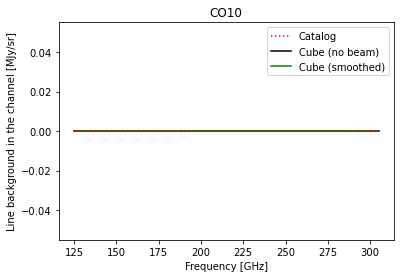

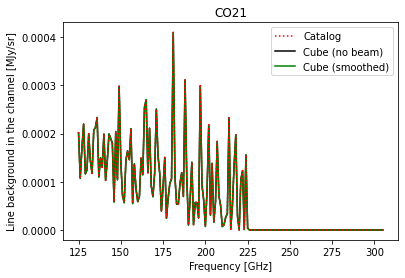

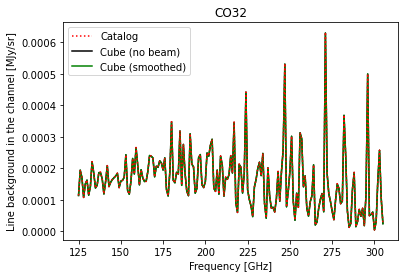

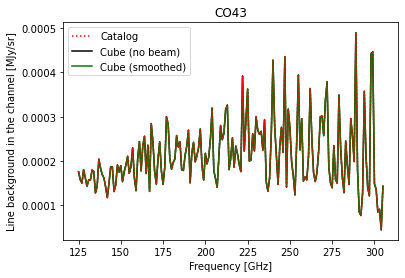

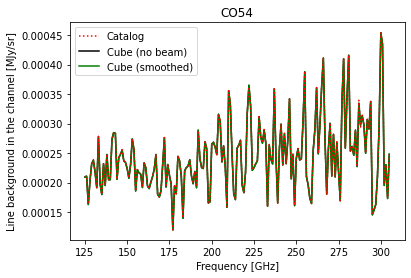

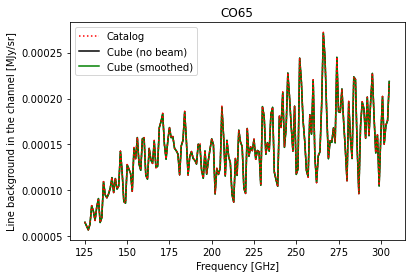

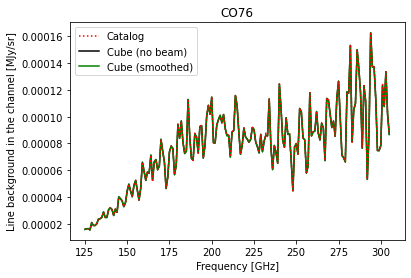

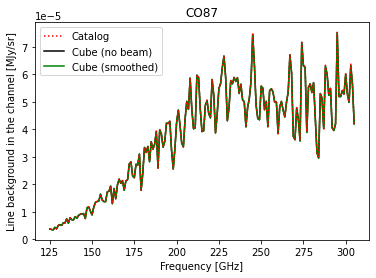

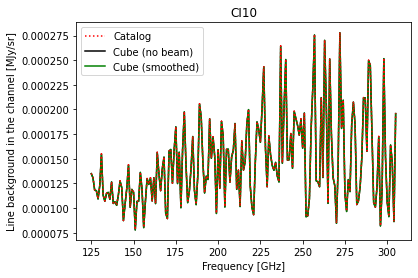

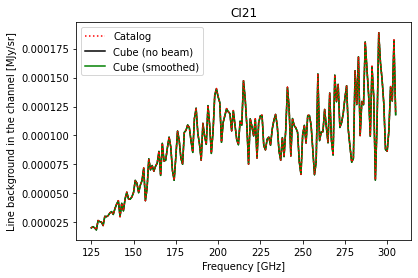

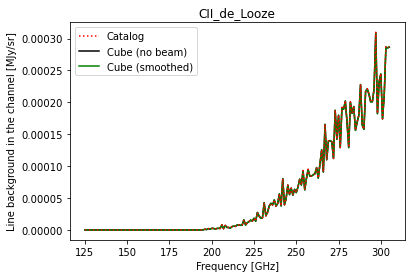

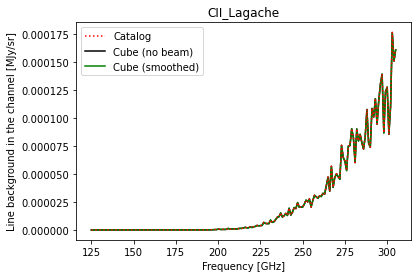

In [10]:
for k, rest_freq, line in zip(range(0, len(line_list)), rest_freq_list, line_list):
    plt.plot(freq, line_background_MJy_sr[:,k], 'r:', label = 'Catalog')
    plt.plot(freq, line_background_cube_MJy_sr[:,k,0], 'k', zorder = 1, label = 'Cube (no beam)')
    plt.plot(freq, line_background_cube_MJy_sr[:,k,1], 'g', zorder = 1, label = 'Cube (smoothed)')
    plt.xlabel('Frequency [GHz]') 
    plt.ylabel('Line background in the channel [MJy/sr]')
    plt.title(line)
    plt.legend()
    plt.show()

In [11]:
#pickle.dump(line_background_MJy_sr, open('SIDES_line_background_MJy_sr.p', 'wb'))

In [12]:
#polynome fort the high SFRD model
pcorr = np.poly1d([ 5.92620521e-03, -1.71971131e-01,  1.70305161e+00, -7.33213631e+00, 11.568763335091798])

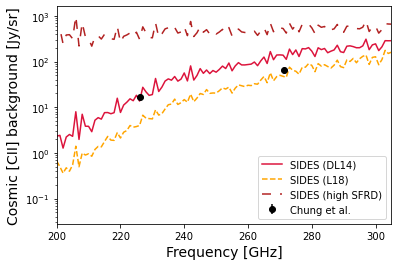

<Figure size 432x288 with 0 Axes>

In [13]:
#Nice paper plot to compare the [CII] intensity with other models

label = ['SIDES (DL14)', 'SIDES (L18)', 'SIDES (high SFRD)']
color = ['crimson', 'orange', 'firebrick']
linestyle = ['-', '--', (0, (6, 6))]
k_list=[10,11,10]

corr = [1.,1.,10.**(-1.*pcorr(1900/freq-1.))]

for k in range(0,len(label)):
    plt.plot(freq, 1.e6*corr[k] * line_background_cube_MJy_sr[:,k_list[k],0], 'k', zorder = 1,
             label = label[k], color = color[k], linestyle = linestyle[k])
    
plt.errorbar(1900 / (1.+np.array([6., 7.4])), [64.75,16.58], 
             yerr = [[3.08,0.66],[2.33,0.69]], fmt = 'ko', label = 'Chung et al.')

plt.xlim([200., 305.])
plt.yscale('log')
plt.xlabel('Frequency [GHz]', size = 14) 
plt.ylabel('Cosmic [CII] background [Jy/sr]', size = 14)
plt.legend()
plt.show()

plt.savefig('CII_line_background.pdf', dpi = 150)